# test to load local package

#### try on dataset c20200927 c20201113 in folder SPOTSAR/test_data


In [1]:
# import external packages
import numpy as np
import pandas as pd
import numba
from numba import vectorize
import glob # for file search
import copy
import os # operating system stuff
import re # regex
import fastparquet # fast read/write for large data structures
import sklearn.preprocessing as pre # for data normalisation
from sklearn.metrics import pairwise_distances

import geopandas as gpd
import rasterio as rio
import rasterio.mask
from rasterio.plot import plotting_extent
from shapely.geometry import Polygon
from shapely.geometry.point import Point
import pyproj
from pyproj import CRS
from inpoly import inpoly2 # for fast inpolygon checks
import utm


import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from matplotlib import cm as mpl_cm
from matplotlib import colors as mcolors 

from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar scaling
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
from matplotlib import rc_file_defaults
rc_file_defaults()
# sns.set(style=None, color_codes=True)



from shapely.geometry import Polygon
from shapely.geometry.point import Point
import datetime

import configparser

from cmcrameri import cm # for scientific colourmaps

###########################
# import main local package
import SPOTSAR_main as sm


In [ ]:
plt.imshow()

In [2]:
import sys
modulenames = set(sys.modules) & set(globals())
allmodules = [sys.modules[name] for name in modulenames]
print(allmodules)

[<module 'copy' from '/Applications/anaconda3/envs/PhD/lib/python3.8/copy.py'>, <module 'fastparquet' from '/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/fastparquet/__init__.py'>, <module 'pyproj' from '/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/pyproj/__init__.py'>, <module 're' from '/Applications/anaconda3/envs/PhD/lib/python3.8/re.py'>, <module 'numba' from '/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/numba/__init__.py'>, <module 'glob' from '/Applications/anaconda3/envs/PhD/lib/python3.8/glob.py'>, <module 'os' from '/Applications/anaconda3/envs/PhD/lib/python3.8/os.py'>, <module 'configparser' from '/Applications/anaconda3/envs/PhD/lib/python3.8/configparser.py'>, <module 'utm' from '/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/utm/__init__.py'>, <module 'sys' (built-in)>, <module 'datetime' from '/Applications/anaconda3/envs/PhD/lib/python3.8/datetime.py'>, <module 'rasterio' from '/Applications/anaconda3/envs/Ph

In [3]:
################ Define user INPUTS #######################
######## please edit the values of this block only ########
###########################################################

# define hillshade file
HS_FILE = './test_data/DEM/TDX_Merapi_WGS84_HS.tif'

# define lon and lat files
LON_FILE = './test_data/CSK_dsc/geo/20200910.lon'
LAT_FILE = './test_data/CSK_dsc/geo/20200910.lat'

# define parameter text file
PARAM_FILE = './test_data/CSK_dsc/params.txt'

# define map region of interest
lon_lims = [110.425, 110.45]
lat_lims = [-7.555, -7.535]

# define colour range {min max} (min = -max)
vmax = 3 # range of colourscale in meters

# define file names for data, lon and lat
DIRECTORY_PATH = "./test_data/CSK_dsc/OFFS/"
# define path to ccp and ccs files
DIRECTORY_PATH_CCS = "./test_data/CSK_dsc/CCS/"

# Set the regular expression pattern to match the file names
PATTERN = r"^c[0-9]+_c[0-9]+_disp_[0-9]+_[0-9]+\.txt$"
# Set the regular expression pattern to match the ccs file names
PATTERN_CCS = r"^c[0-9]+_c[0-9]+_ccs_[0-9]+_[0-9]+$"



In [4]:
# open hillshade file and re-order offset and CCS files

# open hill shade file with rasterio
DEM_HS = rio.open(HS_FILE)
SHADING = DEM_HS.read(1,masked=True) # rasterio bands are indexed from 1

# extract DEM extent
DEM_EXTENT=[DEM_HS.bounds.left,DEM_HS.bounds.right,DEM_HS.bounds.bottom,DEM_HS.bounds.top]

# reorder file using Post_processing.reorder_files
matching_files = sm.Post_processing.reorder_files(DIRECTORY_PATH,PATTERN,0)
matching_files_ccs = sm.Post_processing.reorder_files(DIRECTORY_PATH_CCS,PATTERN_CCS,0)

# test if file ordering has worked
print(matching_files)
print(matching_files_ccs)

['c20200927_c20201113_disp_42_20.txt', 'c20200927_c20201113_disp_74_36.txt', 'c20200927_c20201113_disp_108_52.txt', 'c20200927_c20201113_disp_140_68.txt', 'c20200927_c20201113_disp_174_84.txt', 'c20200927_c20201113_disp_206_100.txt', 'c20200927_c20201113_disp_240_116.txt', 'c20200927_c20201113_disp_272_132.txt', 'c20200927_c20201113_disp_306_148.txt', 'c20200927_c20201113_disp_340_164.txt', 'c20200927_c20201113_disp_372_180.txt']
['c20200927_c20201113_ccs_42_20', 'c20200927_c20201113_ccs_74_36', 'c20200927_c20201113_ccs_108_52', 'c20200927_c20201113_ccs_140_68', 'c20200927_c20201113_ccs_174_84', 'c20200927_c20201113_ccs_206_100', 'c20200927_c20201113_ccs_240_116', 'c20200927_c20201113_ccs_272_132', 'c20200927_c20201113_ccs_306_148', 'c20200927_c20201113_ccs_340_164', 'c20200927_c20201113_ccs_372_180']


In [5]:
# read parameters from text file
config = configparser.ConfigParser()
config.read(PARAM_FILE)
WIDTH = int(config.get('params', 'width'))
LINES = int(config.get('params', 'lines'))
WIDTH_CCS = int(config.get('params', 'width_ccs'))
LINES_CCS = int(config.get('params', 'lines_ccs'))
R_START = int(config.get('params', 'r_start'))
A_START = int(config.get('params', 'a_start'))
R_STEP = int(config.get('params', 'r_step'))
A_STEP = int(config.get('params', 'a_step'))
HEADING = float(config.get('params', 'heading'))
MEAN_INC = float(config.get('params', 'mean_inc'))

In [6]:

# load data from files into class multi-kernel
datastack = sm.Post_processing.MultiKernel(DIRECTORY_PATH,
                                           matching_files,
                                           DIRECTORY_PATH_CCS,
                                           matching_files_ccs,
                                           LAT_FILE,
                                           LON_FILE,
                                           HEADING,
                                           MEAN_INC,
                                           LINES_CCS,
                                           WIDTH_CCS)
# We need to assign some data not stored in the disp.txt files.
datastack.get_params_from_file_name()
datastack.get_latlon_from_file(WIDTH)
datastack.add_lat_lon_to_data(R_START,A_START)
datastack.crop_stack_ccs(R_STEP,A_STEP)
# the object datastack now has several attributes associated with the whole dataset (e.g., date1, date2, heading)
# Next we add all the offset data (disp.txt) to the stack
stacked_data = datastack.assign_data_to_stack(R_STEP,A_STEP)
# The attribute 'Stack' we find a list of single-kernel objects which contain the actual offset data, ccp and ccs data and the coordinates.




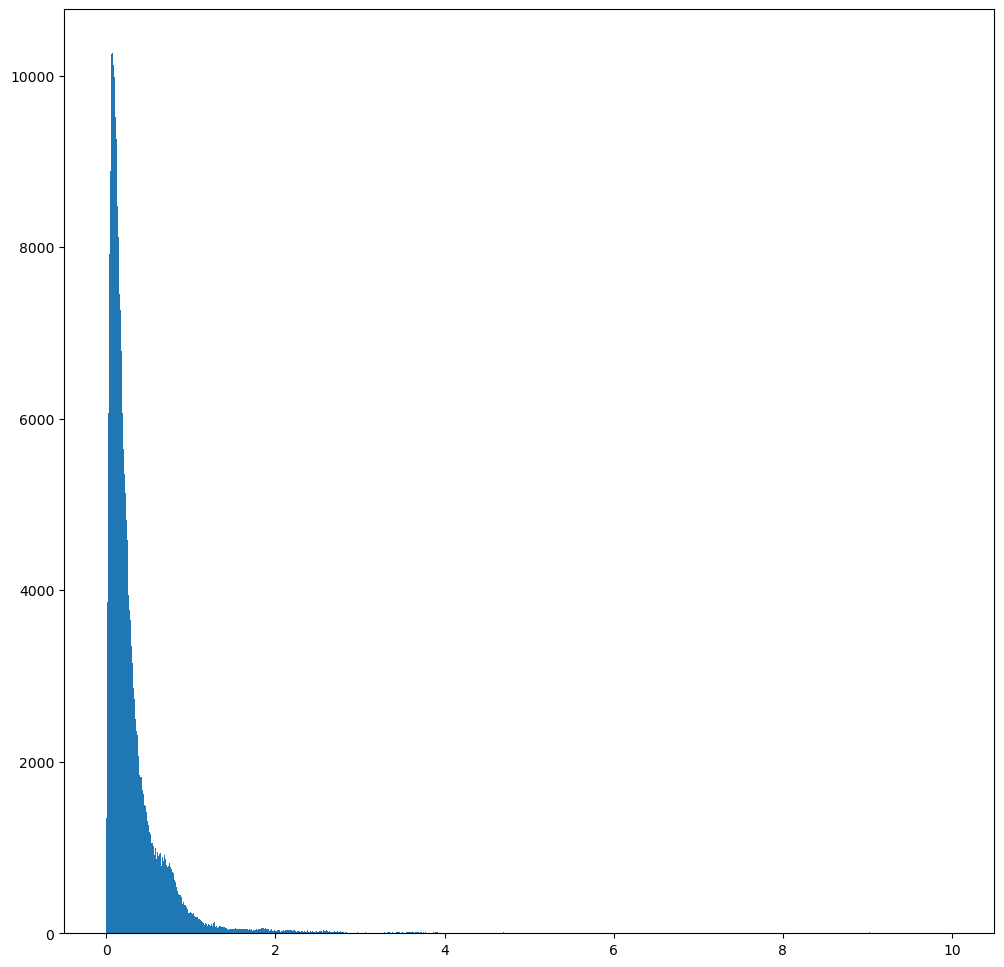

In [7]:
# test some plotting functions
# next to do 8
test_obj = stacked_data[4]
sm.plot.plot_hist(test_obj,'Mag_vec', 1000,[],1, [0,10])
R_off_compare = getattr(test_obj,'R_off')
A_off_compare = getattr(test_obj,'A_off')
lon_off_compare = getattr(test_obj,'Lon_off')
lat_off_compare = getattr(test_obj,'Lat_off')

In [8]:
# print vector field
%matplotlib osx

# sm.plot.plot_vec_attr(test_obj,'Phase',10,50,[0,360],1,shading,DEM_extent)
sm.plot.plot_vec_attr(test_obj,'Phase',8,50,0.01,[0,360],5,SHADING,DEM_EXTENT,[-7.55, -7.53],[110.43,110.46])


In [9]:
# query points
q1 = [110.446216,-7.536389] # stable no veg north
q2 = [110.42647,-7.53297] # stable veg north west
q3 = [110.4421429,-7.5377992] # L1888
q4 = [110.44214,-7.54237] # L1998 large disp
q5 = [110.44013,-7.54678] # stable no veg south
q6 = [110.44200,-7.53604] # L1956 offset gradient
query_points = np.stack((q1,q2,q3,q4,q5,q6))
r = 50

indeces = [0,2,4,6]
stats_list, coordinate_circles = datastack.query_point_stack('R_off_vec',
                                                             query_points[:,1],
                                                             query_points[:,0],
                                                             r,
                                                             indeces)

print(stats_list)

[[42, 20, array([ 0.01397702, -0.0314684 ,  1.505052  ,  2.72681851,  0.04317531,
        0.29078445]), array([ 0.01617422, -0.03155605,  1.57032798,  3.05180095,  0.02181926,
        0.2447759 ]), array([0.46916584, 0.60705792, 0.61806351, 1.4576705 , 0.59688131,
       0.38382368]), array([[-0.43610301,  0.79919182],
       [-1.22633064,  1.66147763],
       [ 0.27832404,  2.72166465],
       [-1.08099768,  4.85721342],
       [-0.88849309,  1.34711525],
       [ 0.02964643,  0.51758116]])], [108, 52, array([ 0.00698769, -0.00932862,  1.58460413,  3.38768477,  0.02570186,
        0.25155241]), array([ 0.01252847, -0.05552147,  1.58209528,  3.38671313,  0.02715618,
        0.25089094]), array([0.04678563, 0.38823887, 0.07024511, 0.70172086, 0.02363273,
       0.0283833 ]), array([[-0.1209948 ,  0.08257868],
       [-0.66480456,  1.02403294],
       [ 1.45286944,  1.78957934],
       [ 2.6651    ,  3.89534978],
       [-0.02818057,  0.06979006],
       [ 0.19286397,  0.31262353]])], [1

In [10]:
# 
plt.close('all')
# cross_plot(test_obj,'HDBSCAN_outlier_scores','wL2',0,300)
# sm.plot.cross_plot(test_obj,'HDBSCAN_outlier_scores','wL2',1,300,1)

In [68]:
# perfrom outlier detection and removal for all windows
import time
start = time.time()
for obj in stacked_data:
    min_cluster_size = 64 # smallest minimum cluster size
    print(f'current window size: {obj.R_win}, {obj.A_win}')
    overlap = 4*np.ceil((obj.R_win/R_STEP) * (obj.A_win/A_STEP))
    min_cluster_size = np.max([int(overlap),min_cluster_size])
    min_samples = int(overlap*0.1)

    # min_cluster_size_hdb = 2000 
    # min_cluster_size_lof = 50 
    # run HDBSCAN
    obj.prep_DBSCAN(1,1,100)
    obj.run_PCA(4)
    obj.run_HDBSCAN(min_cluster_size,min_samples,single_cluster,cluster_selection_epsilon)
    obj.run_LOF(n_neighbors=min_cluster_size,algorithm='auto',leaf_size=30,contamination='auto')
    # obj.rem_outliers_HDBSCAN()
    print(f'time: {time.time()-start}')


current window size: 42, 20
time: 67.14832210540771
current window size: 74, 36
time: 136.220144033432
current window size: 108, 52
time: 211.03346610069275
current window size: 140, 68
time: 319.0953640937805
current window size: 174, 84
time: 445.5494990348816
current window size: 206, 100
time: 629.0091750621796
current window size: 240, 116
time: 858.8403809070587
current window size: 272, 132
time: 1126.9826941490173
current window size: 306, 148
time: 1468.8009662628174
current window size: 340, 164
time: 1898.0757100582123
current window size: 372, 180


/Users/markbemelmans/Documents/PhD/projects/SPOTSAR/SPOTSAR_main/Post_processing/singlekernel.py:378: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig3, ax = plt.subplots(1, 5, figsize=(8, 8))


time: 2505.1598529815674


## check outlier detection via confusion matrix

plot for each category and window size:
- number of points in category
- number of points labeled as outlier by HDBSCAN
- number of points labeled as inlier by HDBSCAN

plot confusion matrix of inlier/outlier for each window size


In [70]:
plt.close('all')

In [71]:

count_list = []
for obj in datastack.Stack:
    r_win = getattr(obj,'R_win')
    a_win = getattr(obj,'A_win')
    r_idx = getattr(obj,'R_idx')
    a_idx = getattr(obj,'A_idx')
    HDBSCAN_labels = getattr(obj,'HDBSCAN_labels')
    test_data = pd.read_csv(f'./test_data/CSK_dsc/{r_win}_{a_win}_test_set.csv',header=0).to_numpy()
    print(test_data)
    counts = np.zeros((4,4))
    counts_in = np.zeros((4,4))
    counts_out = np.zeros((4,4))
    
    for test_vec in test_data:
        # print(test_vec)
        idx = np.argwhere((r_idx==int(test_vec[0]))&(a_idx==int(test_vec[1])))
        print(idx)
        
        counts[int(test_vec[2]),int(test_vec[3])] +=1
        if HDBSCAN_labels[idx[0][0],idx[0][1]]== -1:
            counts_out[int(test_vec[2]),int(test_vec[3])] +=1
        else:
            counts_in[int(test_vec[2]),int(test_vec[3])] +=1
    count_list.append((r_win,a_win,counts,counts_in,counts_out))
print(count_list)

[[3.4560e+03 6.8880e+03 3.0000e+00 0.0000e+00]
 [7.8480e+03 4.6200e+03 0.0000e+00 0.0000e+00]
 [8.9280e+03 6.7440e+03 3.0000e+00 0.0000e+00]
 ...
 [4.4400e+03 5.4600e+03 3.0000e+00 0.0000e+00]
 [1.0776e+04 7.5120e+03 0.0000e+00 0.0000e+00]
 [1.0536e+04 3.0000e+02 1.0000e+00 0.0000e+00]]
[[135 565]]
[[318 376]]
[[363 553]]
[[279 370]]
[[113 732]]
[[354 626]]
[[  6 490]]
[[232 730]]
[[424 338]]
[[ 89 356]]
[[438 163]]
[[129 608]]
[[102 220]]
[[ 13 509]]
[[391 656]]
[[160 705]]
[[43 20]]
[[197  76]]
[[ 47 258]]
[[332 546]]
[[403 485]]
[[296 348]]
[[407 672]]
[[302   8]]
[[445 329]]
[[326 177]]
[[404 573]]
[[201 562]]
[[176 267]]
[[284  57]]
[[173  73]]
[[137 152]]
[[244 326]]
[[67 38]]
[[339 275]]
[[ 72 235]]
[[177  66]]
[[ 10 238]]
[[127 455]]
[[ 46 623]]
[[127  89]]
[[322 122]]
[[350 412]]
[[ 13 441]]
[[116 199]]
[[333  84]]
[[365 367]]
[[ 68 317]]
[[179 482]]
[[105 715]]
[[197 727]]
[[393 419]]
[[230 263]]
[[ 86 258]]
[[346   8]]
[[238  30]]
[[278 604]]
[[151 586]]
[[203 426]]
[[373 27

In [72]:
from sklearn import metrics


fig, axes = plt.subplots(3,11)

for idx, (r_win, a_win, counts, count_in,count_out) in enumerate(count_list):
    # print(idx,counts)
    axes[0,idx].imshow(counts)
    axes[0,idx].set_title(f'{r_win}, {a_win}')
    axes[1,idx].imshow(count_in/counts,vmin=0,vmax=1)
    # axes[1,idx].set_title(f'{r_win}, {a_win}')
    axes[2,idx].imshow(count_out/counts,vmin=0,vmax=1)
    # axes[2,idx].set_title(f'{r_win}, {a_win}')
    axes[0,idx].set_xticks([0,1,2,3])
    axes[0,idx].set_yticks([0,1,2,3])
    axes[1,idx].set_xticks([0,1,2,3])
    axes[1,idx].set_yticks([0,1,2,3])
    axes[2,idx].set_xticks([0,1,2,3])
    axes[2,idx].set_yticks([0,1,2,3])
fig.tight_layout()

axes[0,5].set_xlabel('deformation signal? (No Hi conf.|No Lo conf.|Yes Lo conf.|Yes Hi conf.)')
axes[1,0].set_ylabel('[out|in]lier (Out Hi conf.|Out Lo conf. |In Lo conf. |In Hi conf.)')


fig, axes = plt.subplots(3,5)

for idx, ((r_win, a_win, counts, count_in,count_out),ax) in enumerate(zip(count_list,axes.ravel())):

    TP = np.sum(count_in[2:4,:])
    FP = np.sum(count_in[0:2,:])
    FN = np.sum(count_out[2:4,:])
    TN = np.sum(count_out[0:2,:])
    conf_mat = np.reshape([TP, FP,FN, TN],(2,2))
    TPR = TP/(TP+FN)
    FNR = FN/(TP+FN)
    TNR = TN/(TN+FP)
    FPR = FP/(TN+FP)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1_score = 2*(precision*recall)/(precision+recall)

    # flipped positive/negative

    precision_out = TN/(TN + FN)
    recall_out = TN/(TN+FP)
    F1_score_out = 2*(precision_out*recall_out)/(precision_out+recall_out)

    print(f'{r_win} {a_win}: TP:{TP}, FP:{FP}, TN:{TN}, FN"{FN},')
    print(f'{r_win} {a_win}: precission:{precision}, recall:{recall}, f1_score:{F1_score}')
    print(f'{r_win} {a_win}: precission_out:{precision_out}, recall_out:{recall_out}, f1_score_out:{F1_score_out}')

    ax.imshow(conf_mat)
    ax.set_title(f'{r_win} {a_win}')
    ax.text(0,0,f'{TP}',ha='center',backgroundcolor=[1,1,1,0.5])
    ax.text(0,1,f'{FP}',ha='center',backgroundcolor=[1,1,1,0.5])
    ax.text(1,0,f'{FN}',ha='center',backgroundcolor=[1,1,1,0.5])
    ax.text(1,1,f'{TN}',ha='center',backgroundcolor=[1,1,1,0.5])

[ax.set_axis_off() for ax in axes.ravel()]


/var/folders/m9/32v45xkn4zx6js6htb1prb2r0000gn/T/ipykernel_14214/3878871728.py:10: RuntimeWarning: invalid value encountered in divide
  axes[1,idx].imshow(count_in/counts,vmin=0,vmax=1)
/var/folders/m9/32v45xkn4zx6js6htb1prb2r0000gn/T/ipykernel_14214/3878871728.py:12: RuntimeWarning: invalid value encountered in divide
  axes[2,idx].imshow(count_out/counts,vmin=0,vmax=1)


42 20: TP:348.0, FP:105.0, TN:33.0, FN"0.0,
42 20: precission:0.7682119205298014, recall:1.0, f1_score:0.8689138576779027
42 20: precission_out:1.0, recall_out:0.2391304347826087, f1_score_out:0.3859649122807018
74 36: TP:338.0, FP:53.0, TN:26.0, FN"0.0,
74 36: precission:0.8644501278772379, recall:1.0, f1_score:0.9272976680384087
74 36: precission_out:1.0, recall_out:0.3291139240506329, f1_score_out:0.4952380952380952
108 52: TP:490.0, FP:63.0, TN:34.0, FN"1.0,
108 52: precission:0.8860759493670886, recall:0.9979633401221996, f1_score:0.9386973180076629
108 52: precission_out:0.9714285714285714, recall_out:0.35051546391752575, f1_score_out:0.5151515151515151
140 68: TP:391.0, FP:36.0, TN:47.0, FN"12.0,
140 68: precission:0.9156908665105387, recall:0.9702233250620348, f1_score:0.9421686746987953
140 68: precission_out:0.7966101694915254, recall_out:0.5662650602409639, f1_score_out:0.6619718309859155
174 84: TP:361.0, FP:57.0, TN:7.0, FN"0.0,
174 84: precission:0.8636363636363636, recal

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [73]:
sm.plot.plot_vec_attr(datastack.Stack[6],'LOF_outlier_scores',3,50,0.01,[-10,0],1,SHADING,DEM_EXTENT,[-7.546, -7.533],[110.435,110.450])
sm.plot.plot_vec_attr(datastack.Stack[6],'HDBSCAN_labels',3,50,0.01,[-1,1],1,SHADING,DEM_EXTENT,[-7.546, -7.533],[110.435,110.450])
# sm.plot.plot_hist(datastack.Stack[6],'LOF_outlier_scores',100)

In [74]:
from sklearn import metrics
from matplotlib.collections import LineCollection

fig,axes = plt.subplots(4,3,figsize=(10,10))

count_list = [0,1,2,3,4,5,6,7,8,9,10]
stack_list = [datastack.Stack[idx] for idx in count_list]
for (obj,ax) in zip(stack_list,axes.ravel()):
    r_win = getattr(obj,'R_win')
    a_win = getattr(obj,'A_win')
    r_idx = getattr(obj,'R_idx')
    a_idx = getattr(obj,'A_idx')
    HDBSCAN_labels = getattr(obj,'HDBSCAN_probabilities')
    GLOSH_labels = getattr(obj,'HDBSCAN_outlier_scores')
    LOF_labels = getattr(obj,'LOF_outlier_scores')
    Mag_labels = getattr(obj,'Mag')
    # HDBSCAN_labels[HDBSCAN_labels>1] = 1
    test_data = pd.read_csv(f'./test_data/CSK_dsc/{r_win}_{a_win}_test_set.csv',header=0).to_numpy()
    test_labels = -1 * np.ones(np.shape(test_data[:,1]))
    test_labels[test_data[:,2]>1] = 1

    Mag_test_labels = np.full(np.shape(test_labels),np.nan)
    HDBSCAN_test_labels = np.full(np.shape(test_labels),np.nan)
    GLOSH_test_labels = np.full(np.shape(test_labels),np.nan)
    LOF_test_labels = np.full(np.shape(test_labels),np.nan)
    for row_id, test_vec in enumerate(test_data):
        idx = np.argwhere((r_idx==int(test_vec[0]))&(a_idx==int(test_vec[1])))
        
        Mag_test_labels[row_id]     = Mag_labels[idx[0][0],idx[0][1]]
        HDBSCAN_test_labels[row_id] = HDBSCAN_labels[idx[0][0],idx[0][1]]
        GLOSH_test_labels[row_id]   = GLOSH_labels[idx[0][0],idx[0][1]]
        LOF_test_labels[row_id]     = LOF_labels[idx[0][0],idx[0][1]]

    # checks probability of data belonging to a cluster. outliers have probability 0
    fpr_mag, tpr_mag, thresh_mag = metrics.roc_curve(test_labels,-Mag_test_labels) 
    auc_mag = metrics.roc_auc_score(test_labels,-Mag_test_labels)
    # checks probability of data belonging to a cluster. outliers have probability 0
    fpr_hdb, tpr_hdb, thresh_hdb = metrics.roc_curve(test_labels,HDBSCAN_test_labels) 
    auc_hdb = metrics.roc_auc_score(test_labels,HDBSCAN_test_labels)
    # negative test labels to get outliers as the positive
    fpr_glsh, tpr_glsh, thresh_glsh = metrics.roc_curve(test_labels,1-GLOSH_test_labels)
    auc_glsh = metrics.roc_auc_score(test_labels,1-GLOSH_test_labels)
    # negative test labels to get outliers as the positive, negative LOF score to reverse negative LOF back to LOF to check for outliers
    fpr_lof, tpr_lof, thresh_lof = metrics.roc_curve(test_labels,LOF_test_labels) 
    auc_lof = metrics.roc_auc_score(test_labels,LOF_test_labels)


    ax.plot(fpr_mag,tpr_mag,label=f'mag auc:{auc_mag:1.4f}')
    ax.plot(fpr_hdb,tpr_hdb,label=f'HDBSCAN auc:{auc_hdb:1.4f}')
    ax.plot(fpr_glsh,tpr_glsh,label=f'GLOSH auc:{auc_glsh:1.4f}')
    ax.plot(fpr_lof,tpr_lof,label=f'LOF auc:{auc_lof:1.4f}')
    ax.set_aspect('equal')
    ax.set_axis_off()
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    ax.set_title(f'win size: r:{r_win} a:{a_win}')
    ax.legend()

# axes.ravel()[-1].set_axis_off()
fig.tight_layout()
# print(count_list)

1   HIToolbox                           0x00007ff81d03c726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff81cfabce3 _ZN15MenuBarInstance21UpdateAggregateUIModeE21MenuBarAnimationStylehhh + 1125
3   HIToolbox                           0x00007ff81d03c173 _ZN15MenuBarInstance19SetFullScreenUIModeEjj + 175
4   AppKit                              0x00007ff816b09287 -[NSApplication _setPresentationOptions:instance:flags:] + 1145
5   AppKit                              0x00007ff81695e055 -[NSApplication _updateFullScreenPresentationOptionsForInstance:] + 582
6   AppKit                              0x00007ff8173ac7f0 -[_NSFullScreenSpace(PresentationInstance) activateFullScreenPresentationOptions] + 207
7   AppKit                              0x00007ff8171ff5d8 -[_NSEnterFullScreenTransitionController _doSucceededToEnterFullScreen] + 721
8   AppKit                              0x00007ff8172000e7 __65-[_NSEnterFullScreenTransitionController

In [75]:
from sklearn import metrics
from matplotlib.collections import LineCollection

fig,axes = plt.subplots(4,3,figsize=(10,10))

count_list = [0,1,2,3,4,5,6,7,8,9,10]
stack_list = [datastack.Stack[idx] for idx in count_list]
for (obj,ax) in zip(stack_list,axes.ravel()):
    r_win = getattr(obj,'R_win')
    a_win = getattr(obj,'A_win')
    r_idx = getattr(obj,'R_idx')
    a_idx = getattr(obj,'A_idx')
    HDBSCAN_labels = getattr(obj,'HDBSCAN_probabilities')
    GLOSH_labels = getattr(obj,'HDBSCAN_outlier_scores')
    LOF_labels = getattr(obj,'LOF_outlier_scores')
    Mag_labels = getattr(obj,'Mag')
    # HDBSCAN_labels[HDBSCAN_labels>1] = 1
    test_data = pd.read_csv(f'./test_data/CSK_dsc/{r_win}_{a_win}_test_set.csv',header=0).to_numpy()
    test_labels = -1 * np.ones(np.shape(test_data[:,1]))
    test_labels[test_data[:,3]>1] = 1

    Mag_test_labels = np.full(np.shape(test_labels),np.nan)
    HDBSCAN_test_labels = np.full(np.shape(test_labels),np.nan)
    GLOSH_test_labels = np.full(np.shape(test_labels),np.nan)
    LOF_test_labels = np.full(np.shape(test_labels),np.nan)
    for row_id, test_vec in enumerate(test_data):
        idx = np.argwhere((r_idx==int(test_vec[0]))&(a_idx==int(test_vec[1])))
        
        Mag_test_labels[row_id] = Mag_labels[idx[0][0],idx[0][1]]
        HDBSCAN_test_labels[row_id] = HDBSCAN_labels[idx[0][0],idx[0][1]]
        GLOSH_test_labels[row_id] = GLOSH_labels[idx[0][0],idx[0][1]]
        LOF_test_labels[row_id] = LOF_labels[idx[0][0],idx[0][1]]

    # checks probability of data belonging to a cluster. outliers have probability 0
    fpr_mag, tpr_mag, thresh_mag = metrics.roc_curve(test_labels,-Mag_test_labels) 
    auc_mag = metrics.roc_auc_score(test_labels,-Mag_test_labels)
    # checks probability of data belonging to a cluster. outliers have probability 0
    fpr_hdb, tpr_hdb, thresh_hdb = metrics.roc_curve(test_labels,HDBSCAN_test_labels) 
    auc_hdb = metrics.roc_auc_score(test_labels,HDBSCAN_test_labels)
    # negative test labels to get outliers as the positive
    fpr_glsh, tpr_glsh, thresh_glsh = metrics.roc_curve(test_labels,1-GLOSH_test_labels)
    auc_glsh = metrics.roc_auc_score(test_labels,1-GLOSH_test_labels)
    # negative test labels to get outliers as the positive, negative LOF score to reverse negative LOF back to LOF to check for outliers
    fpr_lof, tpr_lof, thresh_lof = metrics.roc_curve(test_labels,LOF_test_labels) 
    auc_lof = metrics.roc_auc_score(test_labels,LOF_test_labels)


    ax.plot(fpr_mag,tpr_mag,label=f'mag auc:{auc_mag:1.4f}')
    ax.plot(fpr_hdb,tpr_hdb,label=f'HDBSCAN auc:{auc_hdb:1.4f}')
    ax.plot(fpr_glsh,tpr_glsh,label=f'GLOSH auc:{auc_glsh:1.4f}')
    ax.plot(fpr_lof,tpr_lof,label=f'LOF auc:{auc_lof:1.4f}')
    ax.set_aspect('equal')
    ax.set_axis_off()
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    ax.set_title(f'win size: r:{r_win} a:{a_win}')
    ax.legend()
    
# axes.ravel()[-1].set_axis_off()
fig.tight_layout()

1   HIToolbox                           0x00007ff81d03c726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff81cfabce3 _ZN15MenuBarInstance21UpdateAggregateUIModeE21MenuBarAnimationStylehhh + 1125
3   HIToolbox                           0x00007ff81d03c173 _ZN15MenuBarInstance19SetFullScreenUIModeEjj + 175
4   AppKit                              0x00007ff816b09287 -[NSApplication _setPresentationOptions:instance:flags:] + 1145
5   AppKit                              0x00007ff81695e055 -[NSApplication _updateFullScreenPresentationOptionsForInstance:] + 582
6   CoreFoundation                      0x00007ff8136733d4 __CFNOTIFICATIONCENTER_IS_CALLING_OUT_TO_AN_OBSERVER__ + 137
7   CoreFoundation                      0x00007ff81370d41a ___CFXRegistrationPost_block_invoke + 88
8   CoreFoundation                      0x00007ff81370d369 _CFXRegistrationPost + 536
9   CoreFoundation                      0x00007ff8136468f9 _CFXNotificationPost +

In [60]:
plt.close('all')

In [ ]:
MKA_R_off, MKA_A_off = datastack.Run_MKA([0,2,4,6],comp_lim=0.50)

In [ ]:
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar scaling
from cmcrameri import cm

idx_for_plot = [0,2,4,6]
map_extent = [0,446,150,550]
zoom_extent = [140,240,310,390]

substack = [datastack.Stack[i] for i in idx_for_plot]
stack_R = np.stack([obj.R_off for obj in substack],axis=0)
stack_A = np.stack([obj.A_off for obj in substack],axis=0)

plot_data = [stack_R[idx][map_extent[0]:map_extent[1],map_extent[2]:map_extent[3]] for idx in range(len(idx_for_plot))]
plot_data.append(MKA_R_off[map_extent[0]:map_extent[1],map_extent[2]:map_extent[3]])
plot_data = plot_data + [stack_R[idx][zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]] for idx in range(len(idx_for_plot))]
plot_data.append(MKA_R_off[zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]])
plot_data = plot_data + [np.isnan(stack_R[idx][zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]]) for idx in range(len(idx_for_plot))]
plot_data.append(np.isnan(MKA_R_off)[zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]])

cmaps = [cm.vik,cm.vik,cm.vik,cm.vik,cm.vik,
         cm.vik,cm.vik,cm.vik,cm.vik,cm.vik,
         'Greys','Greys','Greys','Greys','Greys',]
min_clim = [-vmax,-vmax,-vmax,-vmax,-vmax,
            -vmax,-vmax,-vmax,-vmax,-vmax,
            0,0,0,0,0,]

max_clim = [vmax,vmax,vmax,vmax,vmax,
            vmax,vmax,vmax,vmax,vmax,
            1,1,1,1,1,]
all_data_arrays2 = [datastack.Stack[idx] for idx in idx_for_plot]
win_sizes = [str(data.get_window_size()) for data in all_data_arrays2]
win_sizes = win_sizes + ['multi-kernel \naverage']


# initiate figure
textsize = 28
plt.rc('font', size=textsize) 
fig=plt.figure(figsize=(10,10))
gs=GridSpec(3,6) # 3 rows, 5 columns
axes = [fig.add_subplot(gs[i,j]) for i in range(3) for j in range(5)]

for ax,p_data,cmap,clim_min,clim_max in zip(axes,plot_data,cmaps,min_clim,max_clim):
    ax.imshow(p_data,cmap=cmap,vmin=clim_min,vmax=clim_max, interpolation='Nearest')
    ax.set_axis_off()
    
for ax,win_size in zip(axes[0:5],win_sizes):
    ax.add_patch(plt.Rectangle((zoom_extent[2]-map_extent[2], zoom_extent[0]-map_extent[0]), zoom_extent[3]-zoom_extent[2], zoom_extent[1]-zoom_extent[0], ls="-", ec="k", fc="none",
                           ))
    ax.set_title(win_size)

fig.tight_layout()
cbar_pos = axes[4].get_position()
 
cax = plt.axes([cbar_pos.x0+cbar_pos.width + 0.1, cbar_pos.y0-0.08, 0.01, 2 * cbar_pos.height])      
mappable = plt.cm.ScalarMappable(cmap = cm.vik,
                                 norm = plt.Normalize(vmin = -vmax, vmax = vmax))
cbar = fig.colorbar(mappable, cax, orientation = 'vertical')
cbar.set_label('Slant range \noffset [m]', rotation=90, loc= 'center',labelpad=0)

# for ax in axes[0:5]:
#     ax.annotate('slant range',xy=(50,50),xytext=(0,-50),textcoords='offset pixels', xycoords='data',
#                     arrowprops=dict(facecolor='black',arrowstyle='<-'),horizontalalignment='center',verticalalignment='top',rotation=90)
#     ax.annotate('azimuth',xy=(50,50),xytext=(50,0),textcoords='offset pixels' ,xycoords='data',
#                     arrowprops=dict(facecolor='black',arrowstyle='<-'),horizontalalignment='left',verticalalignment='center')
textsize = 24
plt.rc('font', size=textsize) 
for ax in axes[-10:-5]:
    ax.annotate('slant range',xy=(5,5),xytext=(0,-50),textcoords='offset pixels', xycoords='data',
                    arrowprops=dict(facecolor='black',arrowstyle='<-',lw=3),horizontalalignment='center',verticalalignment='top',rotation=90)
    ax.annotate('azimuth',xy=(5,5),xytext=(50,0),textcoords='offset pixels' ,xycoords='data',
                    arrowprops=dict(facecolor='black',arrowstyle='<-',lw=3),horizontalalignment='left',verticalalignment='center')

# fig.tight_layout()
fig.subplots_adjust(hspace=0.05)


In [ ]:
plt.close('all')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import rasterio as rio
import fiona
import geopandas as gpd

import json
from shapely.geometry import Point, LineString, mapping
from functools import partial
from shapely.ops import transform


# get NDVI data
file_name = '../Merapi2021/sentinel2/S2A_MSIL2A_20200821T023551_N0214_R089_T49MDM_20200821T064209.SAFE/GRANULE/L2A_T49MDM_A026970_20200821T025827/IMG_DATA/R10m/T49MDM_20200821T023551_NDVI_10m_WGS84.tif'
# with rio.open(file_name) as src:
#     band1 = src.read(1)
#     print('Band1 has shape', band1.shape)
#     height = band1.shape[0]
#     width = band1.shape[1]
#     cols, rows = np.meshgrid(np.arange(width), np.arange(height))
#     xs, ys = rio.transform.xy(src.transform, rows, cols)
#     ndvi_lons = np.array(xs)
#     ndvi_lats = np.array(ys)
#     ndvi_extent = [src.bounds.left,src.bounds.right,src.bounds.bottom,src.bounds.top]


# define map region of interest
lon_lims = [np.nanmin(lon_off_compare), np.nanmax(lon_off_compare)]
lat_lims = [np.nanmin(lat_off_compare), np.nanmax(lat_off_compare)]
crop_flag=1

# create cropping polygon from ROI
if crop_flag:
    coords = ((lon_lims[0], lat_lims[0]), (lon_lims[0], lat_lims[1]), (lon_lims[1], lat_lims[1]), (lon_lims[1], lat_lims[0]), (lon_lims[0], lat_lims[0]))
    crop_poly = Polygon(coords)
    crop_poly_geojson = gpd.GeoSeries([crop_poly])
    crop_poly_geojson.to_file('./test_data/test_variability_roi.shp',crs="EPSG:4326")

with fiona.open('./test_data/test_variability_roi.shp', "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

# get data and read coords from first file
with rio.open(file_name) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open("./test_Data/ndvi_cropped.tif", "w", **out_meta) as dest:
    dest.write(out_image)



with rio.open("./test_Data/ndvi_cropped.tif") as src:
    ndvi_map = src.read(1)
    print('Band1 has shape', ndvi_map.shape)
    height = ndvi_map.shape[0]
    width = ndvi_map.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rio.transform.xy(src.transform, rows, cols)
    ndvi_lons = np.array(xs)
    ndvi_lats = np.array(ys)
    ndvi_extent = [src.bounds.left,src.bounds.right,src.bounds.bottom,src.bounds.top]


x= cm.get_cmap('Blues_r', 135)
y= cm.get_cmap('YlGn', 135)
z = np.vstack((x(range(135)),
                       y(range(135))))
ndvi_cmap = ListedColormap(z, name='BlYlGn')

In [ ]:
%matplotlib osx

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(ndvi_map,cmap=ndvi_cmap,extent=ndvi_extent,vmin=-1,vmax=1)

In [ ]:
# # test query point

# # query points
# q1 = [110.446216,-7.536389] # stable no veg north
# q2 = [110.42647,-7.53297] # stable veg north west
# q3 = [110.4421429,-7.5377992] # L1888
# q4 = [110.44214,-7.54237] # L1998 large disp
# q5 = [110.44013,-7.54678] # stable no veg south
# q6 = [110.44200,-7.53604] # L1956 offset gradient
# query_points = np.stack((q1,q2,q3,q4,q5,q6))

# r = 50 # radius of 5 meters around point


# # original window size 108-52
# orig_q_mean, orig_q_median, orig_q_std, orig_q_95, coordinate_circles = sm.Post_processing.query_point(lat_off_compare.flatten(),
#                                                                lon_off_compare.flatten(),
#                                                                R_off_compare.flatten(),
#                                                                query_points[:,1],
#                                                                query_points[:,0],
#                                                                r)
# print('\n')
# print(f'Range mean for A, B, C: {orig_q_mean}')
# print(f'Range median for A, B, C: {orig_q_median}')
# print(f'Range standard deviation for A, B, C: {orig_q_std}')
# print(f'Range 95\% confidence interval fro A, B, C: {orig_q_95}')

# # MKA reuslt
# MKA_q_mean, MKA_q_median, MKA_q_std, MKA_q_95, coordinate_circles = sm.Post_processing.query_point(lat_off_compare.flatten(),
#                                                                lon_off_compare.flatten(),
#                                                                MKA_R_off.flatten(),
#                                                                query_points[:,1],
#                                                                query_points[:,0],
#                                                                r)
# print('\n')
# print(f'Range mean for A, B, C: {MKA_q_mean}')
# print(f'Range median for A, B, C: {MKA_q_median}')
# print(f'Range standard deviation for A, B, C: {MKA_q_std}')
# print(f'Range 95\% confidence interval fro A, B, C: {MKA_q_95}')

# # original window size 108-52 azimuth
# orig_q_mean, orig_q_median, orig_q_std, orig_q_95, coordinate_circles = sm.Post_processing.query_point(lat_off_compare.flatten(),
#                                                                lon_off_compare.flatten(),
#                                                                A_off_compare.flatten(),
#                                                                query_points[:,1],
#                                                                query_points[:,0],
#                                                                r)
# print('\n')
# print(f'Azimuth mean for A, B, C: {orig_q_mean}')
# print(f'Azimuth median for A, B, C: {orig_q_median}')
# print(f'Azimuth standard deviation for A, B, C: {orig_q_std}')
# print(f'Azimuth 95\% confidence interval fro A, B, C: {orig_q_95}')

# # MKA reuslt
# MKA_q_mean, MKA_q_median, MKA_q_std, MKA_q_95, coordinate_circles = sm.Post_processing.query_point(lat_off_compare.flatten(),
#                                                                lon_off_compare.flatten(),
#                                                                MKA_A_off.flatten(),
#                                                                query_points[:,1],
#                                                                query_points[:,0],
#                                                                r)
# print('\n')
# print(f'Azimuth mean for A, B, C: {MKA_q_mean}')
# print(f'Azimuth median for A, B, C: {MKA_q_median}')
# print(f'Azimuth standard deviation for A, B, C: {MKA_q_std}')
# print(f'Azimuth 95\% confidence interval fro A, B, C: {MKA_q_95}')


# # NDVI reuslt
# ndvi_q_mean, ndvi_q_median, ndvi_q_std, ndvi_q_95, coordinate_circles = sm.Post_processing.query_point(ndvi_lats.flatten(),
#                                                                ndvi_lons.flatten(),
#                                                                ndvi_map.flatten(),
#                                                                query_points[:,1],
#                                                                query_points[:,0],
#                                                                r)
# print('\n')
# print(f'mean for A, B, C: {ndvi_q_mean}')
# print(f'median for A, B, C: {ndvi_q_median}')
# print(f'standard deviation for A, B, C: {ndvi_q_std}')
# print(f'95\% confidence interval fro A, B, C: {ndvi_q_95}')

In [ ]:
indeces = [0,2,4,6]
stats_list, coordinate_circles = datastack.query_point_stack('A_off_vec',
                                                             query_points[:,1],
                                                             query_points[:,0],
                                                             r,
                                                             indeces)

[q_mean_MKA, q_median_MKA, q_std_MKA, q_95_MKA], coordinate_circles = datastack.query_point_MKA('MKA_A_off',
                                                                                                 query_points[:,1],
                                                                                                 query_points[:,0],
                                                                                                 r)                                                        

In [ ]:
print(stats_list)
# print(q_mean_MKA, q_median_MKA, q_std_MKA, q_95_MKA)
print(MKA_q_mean, MKA_q_median, MKA_q_std, MKA_q_95)

In [ ]:
# make plot for comparison
# 1 original input mid window size
# 2 outlier removed-mka result
# 3 ndvi
from cmcrameri import cm
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

data2plot = [R_off_compare,MKA_R_off,ndvi_map]
lon2plot = [lon_off_compare,lon_off_compare,ndvi_lons]
lat2plot = [lat_off_compare,lat_off_compare,ndvi_lats]
cmaps = [cm.vik,cm.vik,ndvi_cmap]
vmins = [-3,-3,-1]
vmaxs = [3,3,1]
cbar_labels = ['Slant range\noffset [m]', 'Slant range\noffset [m]', 'NDVI [-]']
lon_lims = [110.42, 110.45]
lat_lims = [-7.55, -7.53]
# q1 = [110.446216,-7.536389]
# q2 = [110.427882,-7.530558]
# q3 = [110.4421429,-7.5377992]

distance_meters = sm.plot.get_1deg_dist()


fig, ax = plt.subplots(3,1,figsize=(4,12))
for i,(data,lon_p,lat_p,cmap,vmin,vmax,cbar_label) in enumerate(zip(data2plot,lon2plot,lat2plot,cmaps,vmins,vmaxs,cbar_labels)):
    plot_extent = [np.nanmin(lon_p),np.nanmax(lon_p),np.nanmin(lat_p),np.nanmax(lat_p)]
    plot_data = ax[i].hexbin(lon_p.flatten(),lat_p.flatten(),C=data.flatten(),gridsize=500,cmap=cmap,vmin=vmin,vmax=vmax)
    ax[i].plot(coordinate_circles[0][:,0],coordinate_circles[0][:,1],color='Black',linewidth=3)
    ax[i].plot(coordinate_circles[1][:,0],coordinate_circles[1][:,1],color='Black',linewidth=3)
    ax[i].plot(coordinate_circles[2][:,0],coordinate_circles[2][:,1],color='Black',linewidth=3)
    ax[i].plot(coordinate_circles[3][:,0],coordinate_circles[3][:,1],color='Black',linewidth=3)
    ax[i].plot(coordinate_circles[4][:,0],coordinate_circles[4][:,1],color='Black',linewidth=3)
    ax[i].plot(coordinate_circles[5][:,0],coordinate_circles[5][:,1],color='Black',linewidth=3)
    ax[i].set_xlim(lon_lims)
    ax[i].set_ylim(lat_lims)
    ax[i].set_aspect('equal', 'box')
    ax[i].add_artist(ScaleBar(distance_meters,location='lower left'))
    ax[i].set_axis_off()
    cbar = plt.colorbar(plot_data,ax=ax[i])
    cbar.set_label(cbar_label)

In [ ]:
# make plot for comparison
# 1 original input mid window size
# 2 outlier removed-mka result
# 3 ndvi
from cmcrameri import cm
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

data2plot = [R_off_compare,MKA_A_off]
lon2plot = [lon_off_compare,lon_off_compare,lon_off_compare,lon_off_compare]
lat2plot = [lat_off_compare,lat_off_compare,lon_off_compare,lon_off_compare]
cmaps = [cm.vik,cm.vik,cm.vik,cm.vik]
vmins = [-3,-3,-3,-3]
vmaxs = [3,3,3,3]
cbar_labels = ['Slant range\noffset [m]', 'Azimuth\noffset [m]', 'Slant range\noffset [m]', 'Azimuth\noffset [m]',]
lon_lims = [110.42, 110.45]
lat_lims = [-7.55, -7.53]
# q1 = [110.446216,-7.536389]
# q2 = [110.427882,-7.530558]
# q3 = [110.4421429,-7.5377992]

distance_meters = sm.plot.get_1deg_dist()


fig, ax = plt.subplots(2,2,figsize=(12,12))

for (i,j,data,lon_p,lat_p,cmap,vmin,vmax,cbar_label) in zip([0,0,1,1],[0,1,0,1],data2plot,lon2plot,lat2plot,cmaps,vmins,vmaxs,cbar_labels):
    plot_extent = [np.nanmin(lon_p),np.nanmax(lon_p),np.nanmin(lat_p),np.nanmax(lat_p)]
    plot_data = ax[i,j].hexbin(lon_p.flatten(),lat_p.flatten(),C=data.flatten(),gridsize=500,cmap=cmap,vmin=vmin,vmax=vmax)
    # ax[i].plot(coordinate_circles[0][:,0],coordinate_circles[0][:,1],color='Black',linewidth=3)
    # ax[i].plot(coordinate_circles[1][:,0],coordinate_circles[1][:,1],color='Black',linewidth=3)
    # ax[i].plot(coordinate_circles[2][:,0],coordinate_circles[2][:,1],color='Black',linewidth=3)
    # ax[i].plot(coordinate_circles[3][:,0],coordinate_circles[3][:,1],color='Black',linewidth=3)
    # ax[i].plot(coordinate_circles[4][:,0],coordinate_circles[4][:,1],color='Black',linewidth=3)
    # ax[i].plot(coordinate_circles[5][:,0],coordinate_circles[5][:,1],color='Black',linewidth=3)
    ax[i,j].set_xlim(lon_lims)
    ax[i,j].set_ylim(lat_lims)
    ax[i,j].set_aspect('equal', 'box')
    ax[i,j].add_artist(ScaleBar(distance_meters,location='lower left'))
    ax[i,j].set_axis_off()
    cbar = plt.colorbar(plot_data,ax=ax[i,j])
    cbar.set_label(cbar_label)